# Fertility rate - project for Data Analysis course

### Authors

* Michał Ściubisz - 406285
* Wojciech Tokarz - 407478 

## Problem formulation

In recent decades, fertility rates have exhibited notable fluctuations globally, raising concerns about their implications for population dynamics, economic development, and social welfare. Understanding the intricate interplay between socioeconomic variables and fertility rates is essential for policymakers, economists, and social scientists alike. This project aims to delve into this complex relationship, focusing on the impact of Gross Domestic Product (GDP), education, women's labor force participation, and contraception prevalence on fertility rates.

Creating model in the context of the described problem is to develop a tool that can simulate or predict the relationship between various socioeconomic variables and fertility rates. By doing so it is possible to obtain insight into how changes in these factors might influence fertility rates which might be crucial for economists and social scientists in making informed decisions.

The dataset used for this project is sourced from [ourworldindata](https://ourworldindata.org/). Data related to labor force, GDP and education can be found [here](https://ourworldindata.org/fertility-rate),
the data related to spread of contraception can be found [here](https://ourworldindata.org/grapher/fertility-vs-contraception).
* GDP data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'GDP per capita', 'Population (historical estimates)', 'Continent']
* Labor force data contains information about: ['Entity', 'Code for entity', 'Year', 'Labor force participation rate, female (% of female population ages 15+), 'Fertility rate', 'Population (historical estimates)', 'Continent']
* Eductaion data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'Combined - average years of education for 15-64 years female youth and adults', 'Population (historical estimates)', 'Continent']
* Contraception data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'Contraceptive prevalence, any method (% of married women ages 15-49)', 'Continent']

![title](DAG.jfif)

Directed acyclic graph shown above presents our beliefs on dependencies between chosen parameters. Both 'Education years' and 'Contraceptive prevalence' depend on GDP to some extent and they create fork. It is obvious, that higher GDP per capita in country makes both contraception and education more affordable. Because of this 'GDP per capita' can help isolate direct effects of them on 'Fertility rate'.

'Fertility rate' is a common effect influenced by both  'Education years', 'Contraceptive prevalence' and 'Women labor force rate' (collider). This structure means we have predictors that don't depend directly on each other and can make it easier to predict fertility rate more specifically for the data we predict on. At the same time it makes fitting model more difficult. 

### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from cmdstanpy import CmdStanModel

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Reading data from files

In [2]:
gdp_df = pd.read_csv('/home/children-per-woman-fertility-rate-vs-level-of-prosperity.csv')
labor_df = pd.read_csv('/home/fertility-and-female-labor-force-participation.csv')
education_df = pd.read_csv('/home/womens-educational-attainment-vs-fertility.csv')
contraception_df = pd.read_csv('/home/fertility-vs-contraception.csv')

## Data preprocessing

All data has been cleaned up, all unnecesary columns have been removed. It was performed by using .drop instruction. Also, to make merging data easier to identify, the column name has been changed in some columns by using .rename function. Described processes has been repeated for each dataframe. Removed columns weren't relevant to identify each dataframe or they were useless in terms of analysis.

Since all fertality rates indicators are the same across dataframes, the columns responsible for holding value there were also dropped except for one dataframe.

### Cleaning up GDP dataframe

In [3]:
gdp_df.columns

Index(['Entity', 'Code', 'Year',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'GDP per capita (output, multiple price benchmarks)',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [4]:
gdp_df.drop(columns=['Code', 'Population (historical estimates)', 'Continent'], inplace=True)
gdp_df.rename(columns={'Fertility rate - Sex: all - Age: all - Variant: estimates':'Fertility rate', 'GDP per capita (output, multiple price benchmarks)':'GDP per capita'}, inplace=True)
gdp_df.head()

,Entity,Year,Fertility rate,GDP per capita
0,Abkhazia,2015,NaN,NaN
1,Afghanistan,1950,7.2484,NaN
2,Afghanistan,1951,7.2596,NaN
3,Afghanistan,1952,7.2601,NaN
4,Afghanistan,1953,7.2662,NaN


### Cleaning up Labor dataframe

In [5]:
labor_df.columns

Index(['Entity', 'Code', 'Year',
       'Labor force participation rate, female (% of female population ages 15+) (national estimate)',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [6]:
labor_df.drop(columns=['Code','Population (historical estimates)', 'Continent', 'Fertility rate - Sex: all - Age: all - Variant: estimates'], inplace=True)
labor_df.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (national estimate)':'Labor force rate'}, inplace=True)
labor_df.head()

,Entity,Year,Labor force rate
0,Abkhazia,2015,NaN
1,Afghanistan,1979,6.830
2,Afghanistan,2008,43.790
3,Afghanistan,2012,16.015
4,Afghanistan,2014,25.784


### Cleaning up Education dataframe

In [7]:
education_df.columns

Index(['Entity', 'Code', 'Year',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'Combined - average years of education for 15-64 years female youth and adults',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [8]:
education_df.drop(columns=['Code','Population (historical estimates)', 'Continent', 'Fertility rate - Sex: all - Age: all - Variant: estimates'], inplace=True)
education_df.rename(columns={'Combined - average years of education for 15-64 years female youth and adults':'Education years'}, inplace=True)
education_df.head()

,Entity,Year,Education years
0,Abkhazia,2015,NaN
1,Afghanistan,1950,0.08
2,Afghanistan,1951,NaN
3,Afghanistan,1952,NaN
4,Afghanistan,1953,NaN


### Cleaning up Contraception dataframe

In [9]:
contraception_df.columns

Index(['Entity', 'Code', 'Year', 'Fertility rate, total (births per woman)',
       'Contraceptive prevalence, any method (% of married women ages 15-49)',
       'Continent'],
      dtype='object')

In [10]:
contraception_df.drop(columns=['Code','Continent','Fertility rate, total (births per woman)'], inplace=True)
contraception_df.rename(columns={'Contraceptive prevalence, any method (% of married women ages 15-49)': 'Contraceptive prevalence'}, inplace=True)
contraception_df.head()

,Entity,Year,Contraceptive prevalence
0,Abkhazia,2015,NaN
1,Afghanistan,1960,NaN
2,Afghanistan,1961,NaN
3,Afghanistan,1962,NaN
4,Afghanistan,1963,NaN


### Merging data and preparing data for further analysis

In order to perform some more advanced actions to the dataset, it is necessary to merge dataset in one big dataset so that is easier to perform further analysis. The merged dataframe has multiple NaN values, which will be removed further.

In [11]:
merged_df= gdp_df.merge(labor_df, on=['Entity', 'Year'])\
                           .merge(education_df, on=['Entity', 'Year'])\
                           .merge(contraception_df, on=['Entity', 'Year'])

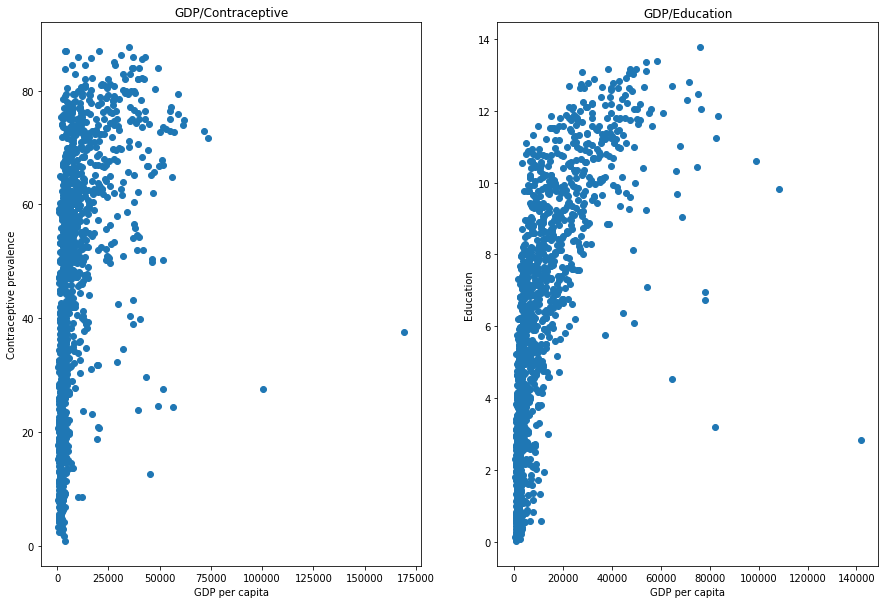

In [72]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('GDP/Contraceptive')
plt.scatter(merged_df['GDP per capita'], merged_df['Contraceptive prevalence'])
plt.ylabel('Contraceptive prevalence')
plt.xlabel('GDP per capita')
plt.subplot(1,2,2)
plt.title('GDP/Education')
plt.scatter(merged_df['GDP per capita'], merged_df['Education years'])
plt.xlabel('GDP per capita')
plt.ylabel('Education')
plt.show()

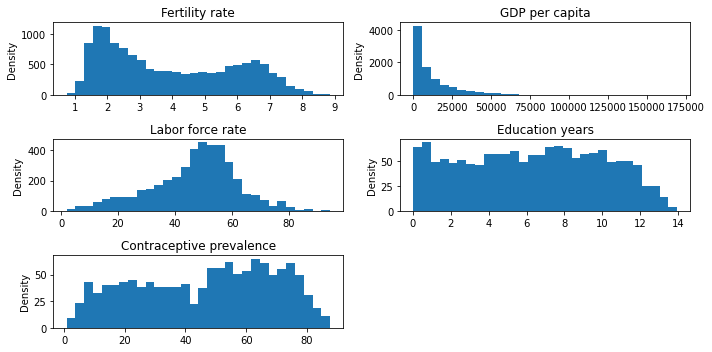

In [13]:
col_list = ['Fertility rate', 'GDP per capita', 'Labor force rate', 'Education years', 'Contraceptive prevalence']

plt.figure(figsize=(10,5))
for idx in range(len(col_list)):
    plt.subplot(3,2,idx+1)
    plt.hist(merged_df[col_list[idx]], bins=30)
    plt.ylabel('Density')
    plt.title(f'{col_list[idx]}')
plt.tight_layout()
plt.show()

In [14]:
records_without_nan = merged_df.notna().all(axis=1)
print(f'Records that do not contain NaN after fully joining tables: {records_without_nan.sum()}')

Records that do not contain NaN after fully joining tables: 96


After joining tables, many of the records turned out to have missing data. It is not acceptable, since having full information about each record is necessary for further analysis. Dropping every record that contains NaN leaves us with only 96 records, which is too few. Because of this, we decided to check which column increases records with missing data the most.

In [15]:
for col in col_list[1:]:
    records_without_nan_dropped = merged_df.drop(columns=col).dropna()
    print(f'Records that do not contain NaN, dropped "{col}": \t{records_without_nan_dropped.shape[0]}')

Records that do not contain NaN, dropped "GDP per capita": 	104
Records that do not contain NaN, dropped "Labor force rate": 	163
Records that do not contain NaN, dropped "Education years": 	602
Records that do not contain NaN, dropped "Contraceptive prevalence": 	632


Column, dropping which leaves the most valid data, is Contraceptive prevalence. However, dropping Education years seems to have nearly the same impact on dataframe. Because of this we decided to plot histograms for both options and decide which one of them provides better data distribution.

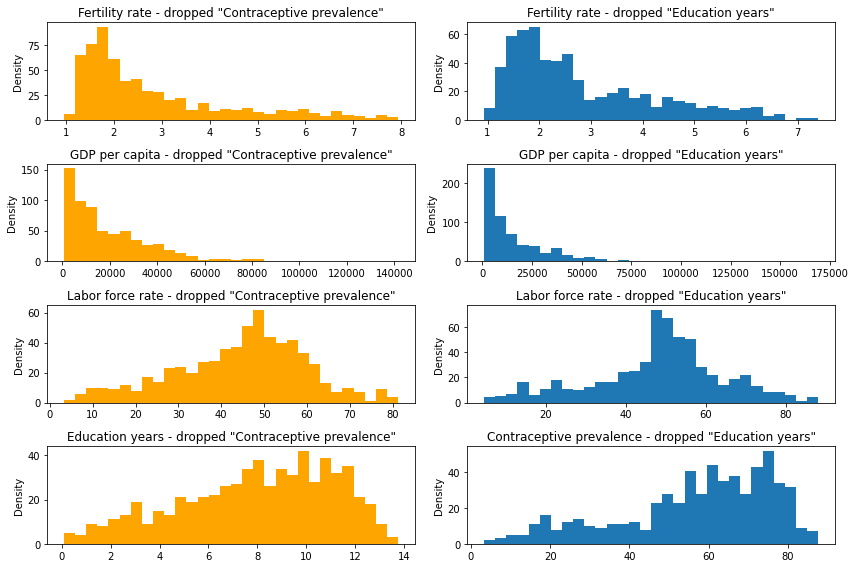

In [16]:
plt.figure(figsize=(12,8))

education_dropped_df = merged_df.drop(columns='Education years').dropna()
contraception_dropped_df = merged_df.drop(columns='Contraceptive prevalence').dropna()
i=0
for idx in range(len(col_list)):
    if col_list[idx] != 'Contraceptive prevalence':
        plt.subplot(4,2,i+1)
        plt.hist(contraception_dropped_df[col_list[idx]], bins=30, color='orange')
        plt.ylabel('Density')
        plt.title(f'{col_list[idx]} - dropped "Contraceptive prevalence"')
        i+=1
    if col_list[idx] != 'Education years':
        plt.subplot(4,2,i+1)
        plt.hist(education_dropped_df[col_list[idx]], bins=30)
        plt.ylabel('Density')
        plt.title(f'{col_list[idx]} - dropped "Education years"')
        i+=1
plt.tight_layout()
plt.show()


Considering histograms for dataframes with dropped columns and the complete one, we decided to drop "Education years". Histograms for this option show better distribution for "Fertality rate" and we believe that this way we will have more accurate predictions.

In [17]:
prior_df = education_dropped_df

We determined that a model created for all data globally might be too general and may not yield satisfactory results because the influence of specific predictors may vary in countries, for instance, rich and poor ones. Therefore, we decided to examine which regions we can divide the existing data into so that the countries are somewhat culturally consistent.

In [18]:
countries_appearance = prior_df['Entity'].value_counts()
countries_appearance[countries_appearance.values>5]

Indonesia             26
Japan                 25
Peru                  18
Philippines           18
Vietnam               17
South Korea           16
United States         15
Pakistan              14
Egypt                 14
United Kingdom        13
Thailand              12
Mexico                11
Dominican Republic    10
Turkey                 9
Bangladesh             8
Mongolia               8
Hong Kong              8
Spain                  7
Russia                 7
Colombia               7
El Salvador            7
Bolivia                7
Netherlands            7
Paraguay               6
Ghana                  6
Senegal                6
Georgia                6
Ecuador                6
Name: Entity, dtype: int64

We decided to separate the data into a few regions that we believed would have more or less the same influence of pedictors on our model.

In [19]:
asia_wealthy = ['Japan', 'South Korea', 'Hong Kong']
asia_poor = ['Indonesia','Vietnam', 'Thailand', 'Philippines', 'Bangladesh', 'Mongolia']
europe = ['United Kingdom', 'Netherlands', 'Germany', 'France', 'Spain', 'Belgium', 'Estonia', 'Russia', 'Georgia', 'Turkey', 'Georgia']
america = ['Peru', 'Dominican Republic', 'United States', 'Mexico', 'Colombia', 'El Salvador', 'Bolivia', 'Paraguay', 'Ecuador']
africa = ['Egypt', 'Pakistan', 'Senegal', 'Palestine', 'Jordan', 'Ghana']

In [20]:
asia_wealthy_df = prior_df[prior_df['Entity'].isin(asia_wealthy)]
asia_poor_df = prior_df[prior_df['Entity'].isin(asia_poor)]
america_df = prior_df[prior_df['Entity'].isin(america)]
europe_df = prior_df[prior_df['Entity'].isin(europe)]
africa_df = prior_df[prior_df['Entity'].isin(africa)]

Then we had to decide which region should we chose. Our selection criterion was whether the data for all countries in a region are consistent, meaning that the influence of independent variables is similar for each country and whether there is a sufficient amount of data. To make this decision, we visualized the data – histograms of fertility rates and plots of the fertility rates versus parameter.

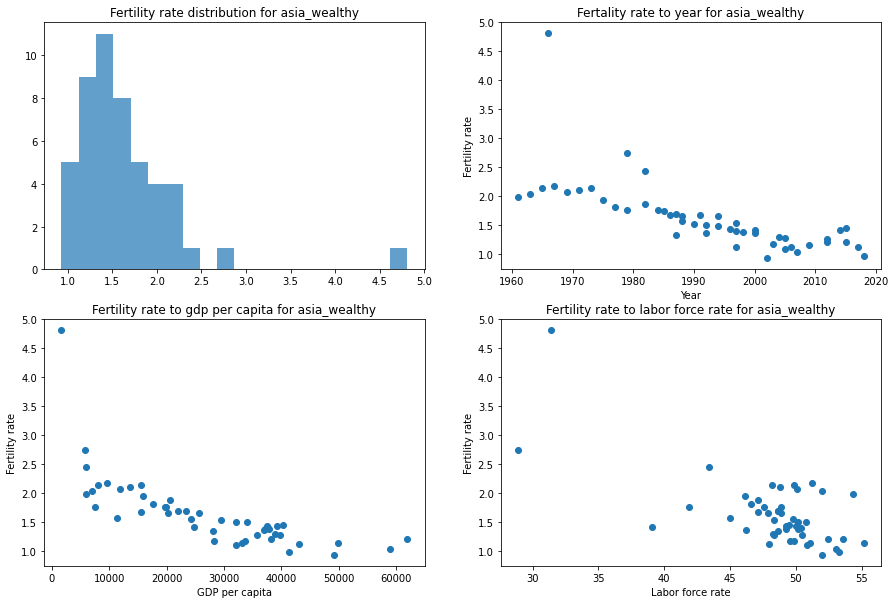

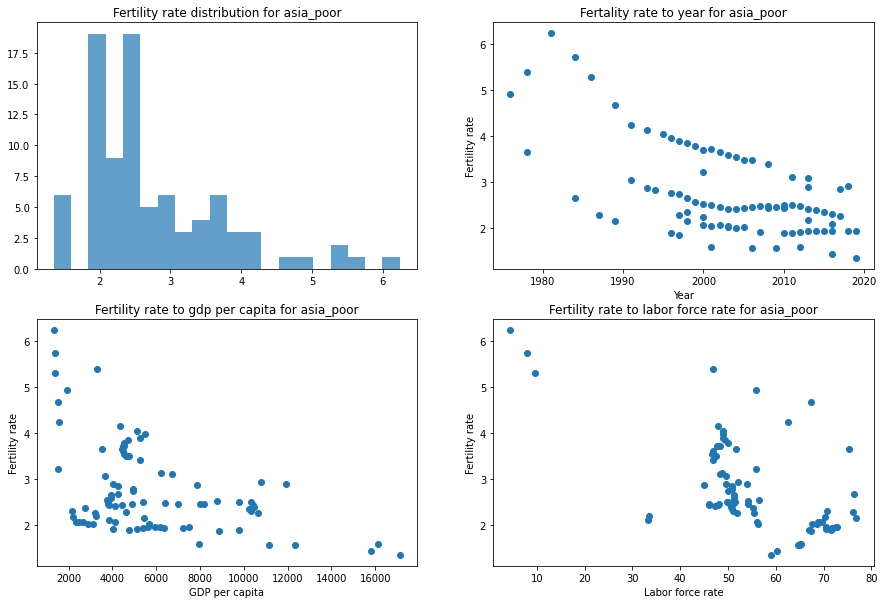

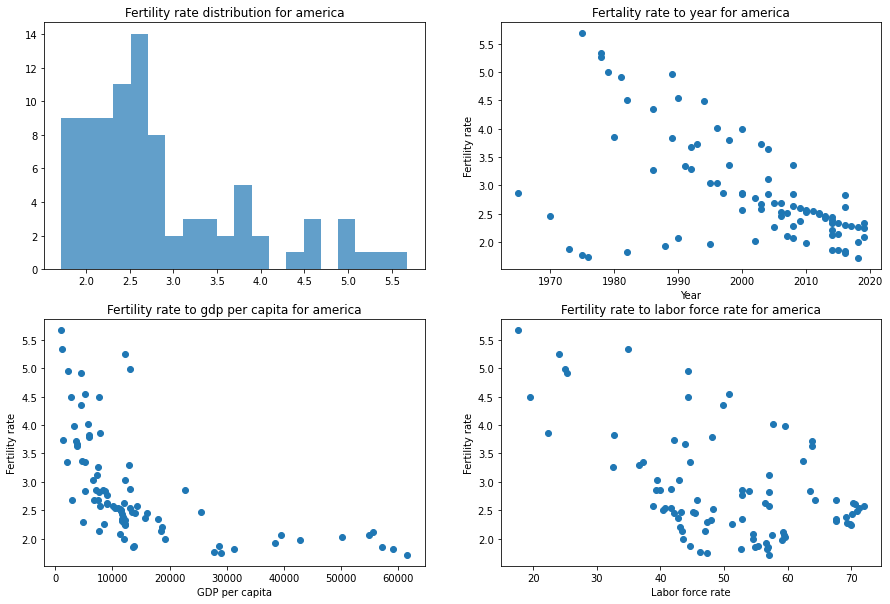

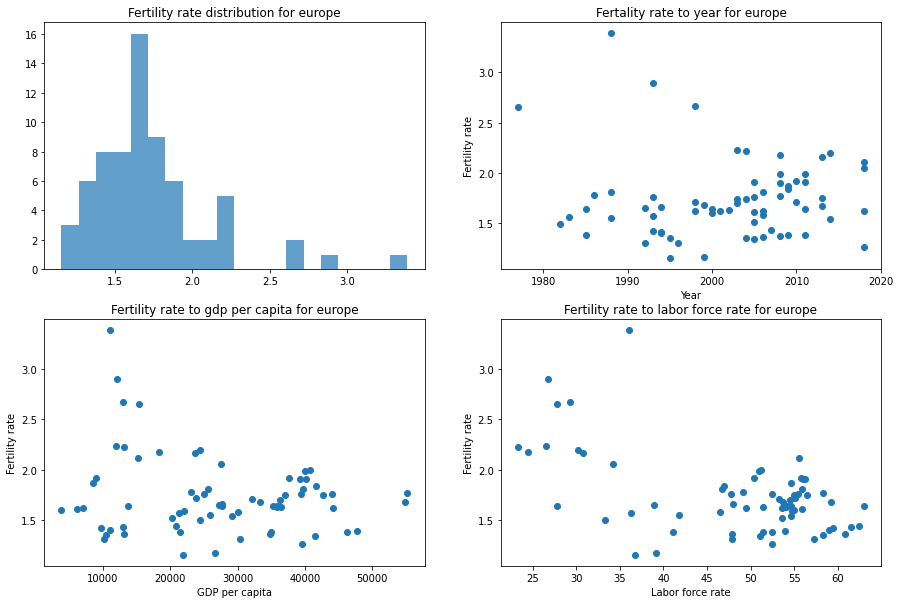

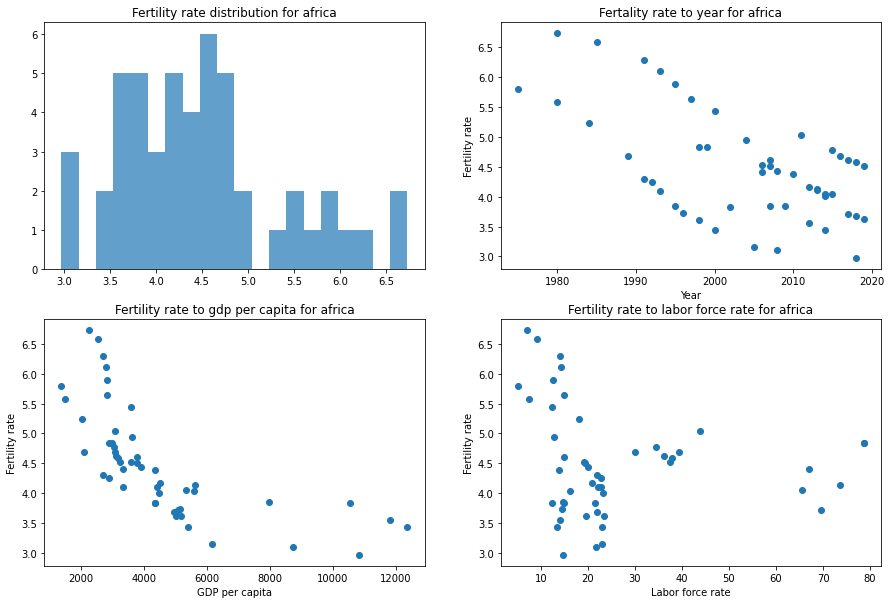

In [21]:
dfs = [asia_wealthy_df, asia_poor_df, america_df, europe_df, africa_df]
name = ['asia_wealthy', 'asia_poor', 'america', 'europe', 'africa']

for idx in range(len(dfs)):
    df = dfs[idx]
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.hist(df['Fertility rate'], bins=20, alpha=0.7)
    plt.title(f'Fertility rate distribution for {name[idx]}')
    plt.subplot(2,2,2)
    plt.scatter(df['Year'], df['Fertility rate'])
    plt.title(f"Fertality rate to year for {name[idx]}")
    plt.xlabel('Year')
    plt.ylabel('Fertility rate')
    plt.subplot(2,2,3)
    plt.scatter(df['GDP per capita'], df['Fertility rate'])
    plt.title(f"Fertility rate to gdp per capita for {name[idx]}")
    plt.xlabel('GDP per capita')
    plt.ylabel('Fertility rate')
    plt.subplot(2,2,4)
    plt.scatter(df['Labor force rate'], df['Fertility rate'])
    plt.title(f"Fertility rate to labor force rate for {name[idx]}")
    plt.xlabel('Labor force rate')
    plt.ylabel('Fertility rate')
    plt.show()


In [22]:
for idx in range(len(dfs)):
    df = dfs[idx]
    region = name[idx]
    print(f'Region {region}, has {len(df)} records')

Region asia_wealthy, has 49 records
Region asia_poor, has 89 records
Region america, has 87 records
Region europe, has 69 records
Region africa, has 50 records


Based on the information above, we chose poor asian countries. They consist of Indonesia, Vietnam, Thailand, Philippines, Bangladesh and Mongolia. Although they might not appear to be fully culturally consistent, the data visible in the charts turned out to be satisfactory and the number of records sufficient.

In [23]:
prior_df = asia_poor_df

The next step was to standardize the data so that the ranges for different parameters were similar. For this task we used MIN-MAX standarization. This ensured that each parameter had an equal influence on the model, focusing on differences in sample values rather than values themselves. Additionally, values were inverted so that for example high GDPs had lower values than low GDPs, reflecting our observation that an increase in any of the parameters tends to have a negative impact on fertility rates. 

In [24]:
col_list = ['GDP per capita', 'Labor force rate', 'Contraceptive prevalence']

for col in col_list:
    max_value = prior_df[col].max()
    min_value = prior_df[col].min()
    print(f"Max value of column {col} is: {max_value} and minimal value is: {min_value}")
    prior_df.loc[:, col] = 1-(prior_df[col]-min_value)/(max_value-min_value) ##MIN_MAX

Max value of column GDP per capita is: 17116.309 and minimal value is: 1325.1575


Max value of column Labor force rate is: 76.82 and minimal value is: 4.48
Max value of column Contraceptive prevalence is: 79.6 and minimal value is: 18.6


/tmp/ipykernel_7754/24705460.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_df.loc[:, col] = 1-(prior_df[col]-min_value)/(max_value-min_value) ##MIN_MAX


In [25]:
prior_df

,Entity,Year,Fertility rate,GDP per capita,Labor force rate,Contraceptive prevalence
841,Bangladesh,1981,6.2392,1.000000,1.000000,1.000000
844,Bangladesh,1984,5.7274,0.997175,0.952170,0.991803
846,Bangladesh,1986,5.2998,0.995845,0.927564,0.890164
849,Bangladesh,1989,4.6765,0.988779,0.130357,0.790164
851,Bangladesh,1991,4.2404,0.985535,0.196986,0.650820
...,...,...,...,...,...,...
12973,Vietnam,2014,1.9500,0.707633,0.057009,0.063934
12974,Vietnam,2015,1.9513,0.692537,0.059842,0.063934
12975,Vietnam,2016,1.9380,0.680613,0.067280,0.032787
12977,Vietnam,2018,1.9371,0.626831,0.088084,0.052459


In order to have some test data, we decided to create our models only for data older than year 2015. Rest of the data was supposed to verify how good our model would predict future fertility rates.

In [26]:
prior_sorted_df = prior_df.sort_values(by='Year')

training_df = prior_sorted_df[prior_sorted_df['Year']<2015]
test_df = prior_sorted_df[prior_sorted_df['Year']>=2015]

## Model

We chose two models:
1. Gamma distribution based only on GDP per capita parameter
2. Gamma distribution based on all three parameters (GDP, contraceptive prevalence, labor force rate)

We decided to take GDP as the only parameter since it is a factor that has a high influence on multiple factors that affect fertility rates in countries (as we could see on the DAG at the beginning of this document). Because of this, we wondered if model based only on GDP would be enough to predict fertility rates correctly.

Second model used all three parameters. We assumed that having more parameters would give more specific predictions. Contraceptive prevalence is for sure a factor that has direct impact on fertility rate as well as labor force rate among women. First of them decreases number of unwanted pregnancies, while second makes it difficult to have children so they are less likely to decide to give birth.

Gamma distribution was chosen for this problem because it best reflects the distribution of fertility data. We researched on what distribution is mostly used for this kind of data and it turned out most of the sources use gamma distribution. We also observed that this distribution seems to fit the data we have very well (based on previous histograms). Example sources:
* https://pubmed.ncbi.nlm.nih.gov/12316244/
* https://www.tandfonline.com/doi/pdf/10.1080/09720502.2007.10700519

Formula we used to calculate shape parameter of gamma distribution was a linear model, where relationship between the dependent variable and predictor or predictors is linear. Below is the formula for first model: 
* shape_adjusted = alpha + beta_gdp * gdp_per_capita[j]
* alpha = normal_rng(mu_alpha, sig_alpha) - element of normal distributon with parameters mu_alpha and sig_alpha
* beta_gdp = normal_rng(mu_beta, sig_beta) - element of normal distributon with parameters mu_beta and sig_beta
* gdp_per_capita[j] - j-th normalized sample of GDP
* mu_alpha - natural logarithm of the mean calculated for fertility rate data
* sig_alpha - absolute value of the natural logarithm of the standard deviation calculated for fertility rate data
* mu_beta, sig_beta - parameters chosen experimentally and passed to model

After calculating 'shape_adjusted' parameter, we passed it to gamma distribution function and calculated predicted fertility rate distribution for j-th sample:
* y_pred[j] = gamma_rng(shape_adjusted, rate)
* rate - parameter chosen experimentally and passed to model

Second model used practically same formulas. The only change was:
* shape_adjusted = alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j])

Instead of multiplying only GDP sample, here we also add labor force and contraceptive prevalence and multiply the sum of them.


## Priors

### GDP

We prepared model for prior analysis with gdp per capita as factor.

In [27]:
gdp_prior = CmdStanModel(stan_file='/home/prior_gdp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Prior model in stan.

In [28]:
"""
data {
  int<lower=0> N;               
  array[N] real gdp_per_capita;
  real mu_alpha;
  real sig_alpha;
  real mu_beta;
  real sig_beta;
  real<lower=0> rate;
}

generated quantities {
  real<lower=0> alpha = normal_rng(mu_alpha, sig_alpha);
  real<lower=0> beta_gdp = normal_rng(mu_beta, sig_beta);

  array[N] real y_pred;
  for (j in 1:N) {
    real shape_adjusted = (alpha + beta_gdp * gdp_per_capita[j]);
    y_pred[j] = gamma_rng(shape_adjusted, rate);
  }
}
"""

'\ndata {\n  int<lower=0> N;               \n  array[N] real gdp_per_capita;\n  real mu_alpha;\n  real sig_alpha;\n  real mu_beta;\n  real sig_beta;\n  real<lower=0> rate;\n}\n\ngenerated quantities {\n  real<lower=0> alpha = normal_rng(mu_alpha, sig_alpha);\n  real<lower=0> beta_gdp = normal_rng(mu_beta, sig_beta);\n\n  array[N] real y_pred;\n  for (j in 1:N) {\n    real shape_adjusted = (alpha + beta_gdp * gdp_per_capita[j]);\n    y_pred[j] = gamma_rng(shape_adjusted, rate);\n  }\n}\n'

We experimented with different parameters in order to get the best coverage of sampled and real data. Below are the results:

In [29]:
data_simulation_gdp = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'mu_alpha': np.log(training_df['Fertility rate'].mean()),
    'sig_alpha': np.abs(np.log(training_df['Fertility rate'].std())),
    'mu_beta': 11,
    'sig_beta': 0.2,
    'rate' : 4
}

We sampled the model with data_simulation_gdp.

In [30]:
R = len(training_df)

sim_gdp = gdp_prior.sample(data=data_simulation_gdp, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_gdp_df = sim_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


We decided to plot 6 histograms for 6 different samples to make sure that our prior parameters are correct. We tested multiple sets of parameters and checked histograms for each of them and eventually chose the one in data_simulation_gdp. Histograms are plotted below.

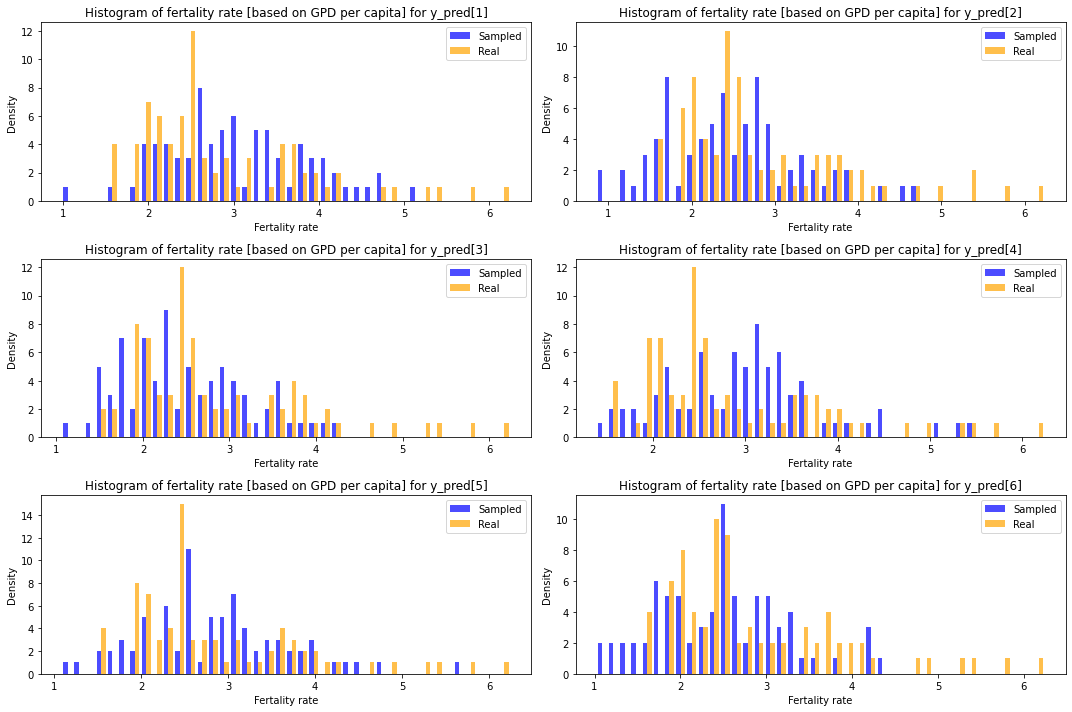

In [31]:
plt.figure(figsize=(15,10))
for idx in range(1,7):
    plt.subplot(3,2,idx)
    plt.title(f'Histogram of fertality rate [based on GPD per capita] for y_pred[{idx}]')
    plt.hist([sim_gdp_df[f'y_pred[{idx}]'], training_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Fertality rate')
    plt.tight_layout()
plt.show()

What we wanted to achieve was both to get the peak near where fertality rate equals 2.5 and the sampled values to be spread from 0 to 6. We achieved a satisfying coverage of sampled and real data. This was done by manipulating mu_beta, sig_beta and rate. Also, we started with mu_alpha and sig_alpha being calculated only as mean and standard deviation. However, this way mu_alpha seemed to be too high and it caused our shape parameter for gamma distribution to be higher than 2. It was problematic, because we noticed that the shape of distribution would fit our data best if we used shape parameter that equals 2 [source](https://en.wikipedia.org/wiki/Gamma_distribution#/media/File:Gamma_distribution_pdf.svg). In order to get closer to the height of the peak we had to increase rate parameter. Increasing it too much caused all the data to move to the left so we had to be careful with it. Increasing mu_beta caused GDP sample to be more significant, and indirectly it increased the spread of the samples.

### Combined parameters

We prepared model for prior analysis with combined parameters.

In [32]:
percentage_prior = CmdStanModel(stan_file='/home/prior_combined.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Prior model in stan:

In [33]:
"""
data {
  int<lower=0> N;               
  array[N] real gdp_per_capita;
  array[N] real labor_force;
  array[N] real contaceptive_prevalence;
  real mu_alpha;
  real sig_alpha;
  real mu_beta;
  real sig_beta;
  real<lower=0> rate;
}

generated quantities {
  real alpha = normal_rng(mu_alpha, sig_alpha);
  real beta_var = normal_rng(mu_beta, sig_beta);

  array[N] real y_pred;
  for (j in 1:N) {
    real shape_adjusted = (alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));
    y_pred[j] = gamma_rng(shape_adjusted, rate);
  }
}
"""

'\ndata {\n  int<lower=0> N;               \n  array[N] real gdp_per_capita;\n  array[N] real labor_force;\n  array[N] real contaceptive_prevalence;\n  real mu_alpha;\n  real sig_alpha;\n  real mu_beta;\n  real sig_beta;\n  real<lower=0> rate;\n}\n\ngenerated quantities {\n  real alpha = normal_rng(mu_alpha, sig_alpha);\n  real beta_var = normal_rng(mu_beta, sig_beta);\n\n  array[N] real y_pred;\n  for (j in 1:N) {\n    real shape_adjusted = (alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));\n    y_pred[j] = gamma_rng(shape_adjusted, rate);\n  }\n}\n'

We experimented with different parameters in order to get the best coverage of sampled and real data. Below are the results:

In [34]:
data_simulation_prior_combined = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'labor_force': training_df['Labor force rate'],
    'contaceptive_prevalence' : training_df['Contraceptive prevalence'], 
    'mu_alpha': np.log(training_df['Fertility rate'].mean()),
    'sig_alpha': np.abs(np.log(training_df['Fertility rate'].std())),
    'mu_beta': 1.5,
    'sig_beta': 0.01,
    'rate' : 1.35
}

We sampled the model with data_simulation_gdp.

In [35]:
R = len(training_df)

sim_combined_prior = percentage_prior.sample(data=data_simulation_prior_combined, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_combined_prior_df = sim_combined_prior.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


We did everything like with the previous model.

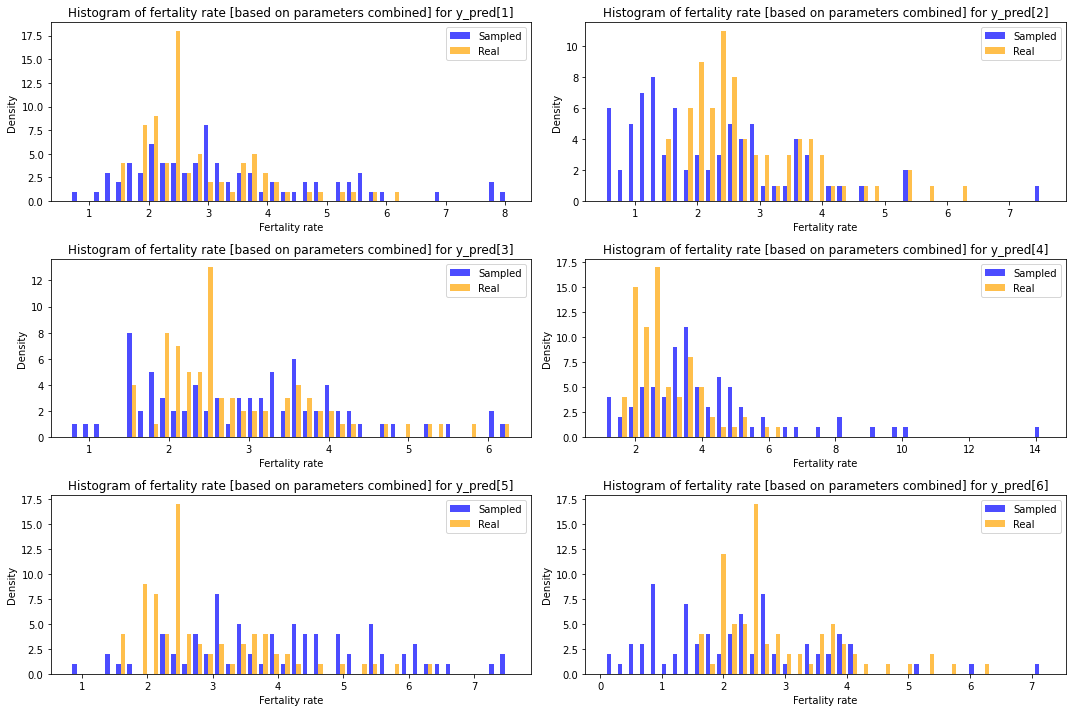

In [36]:
plt.figure(figsize=(15,10))
for idx in range(1,7):
    plt.subplot(3,2,idx)
    plt.title(f'Histogram of fertality rate [based on parameters combined] for y_pred[{idx}]')
    plt.hist([sim_combined_prior_df[f'y_pred[{idx}]'], training_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Fertality rate')
    plt.tight_layout()
plt.show()

In second model we experimented the same way as we did with the first one. The issue here was that we now added 3 parameters together which seemingly decreased coverage on some of the samples. Since the sum of three parameters' samples could be even three times higher, the shape parameter for gamma distribution had to be decreased in some other way. To do this, we decreased mu_beta so the product of mu_beta and summed up parameters was closer to what we had in first model. We also had to decrease rate parameter in order to reduce difference between rate and shape and prevent samples from moving to the left on the histogram. Nevertheless, choosing universal parameters was much more difficult in this case and we decided that results shown above are sufficient. 

## Posteriors analysis - model 1

We prepared model for posterior analysis with gdp per capita as factor.

In [37]:
gdp_posterior = CmdStanModel(stan_file='/home/posterior_gdp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Posterior model in stan:

In [38]:
"""
data {
  int<lower=0> N;               
  array[N] real gdp_per_capita;
  array[N] real fertility_rate;
  real mu_alpha;
  real sig_alpha;
  real mu_beta;
  real sig_beta;
  real<lower=0> rate;
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta_gdp;
}

model {
  alpha ~ normal(mu_alpha, sig_alpha);
  beta_gdp ~ normal(mu_beta, sig_beta);

  for (j in 1:N) {
    real shape_adjust = (alpha + beta_gdp * gdp_per_capita[j]);
    fertility_rate[j] ~ gamma(shape_adjust, rate);
  }
}

generated quantities {
  array[N] real y_pred;
  array[N] real log_likelihood;
  for (j in 1:N) {
    real shape_adjusted = (alpha + beta_gdp * gdp_per_capita[j]);
    y_pred[j] = gamma_rng(shape_adjusted, rate);
    log_likelihood[j] = gamma_lpdf(fertility_rate[j] | shape_adjusted, rate);
  }
}
"""

'\ndata {\n  int<lower=0> N;               \n  array[N] real gdp_per_capita;\n  array[N] real fertility_rate;\n  real mu_alpha;\n  real sig_alpha;\n  real mu_beta;\n  real sig_beta;\n  real<lower=0> rate;\n}\n\nparameters {\n  real<lower=0> alpha;\n  real<lower=0> beta_gdp;\n}\n\nmodel {\n  alpha ~ normal(mu_alpha, sig_alpha);\n  beta_gdp ~ normal(mu_beta, sig_beta);\n\n  for (j in 1:N) {\n    real shape_adjust = (alpha + beta_gdp * gdp_per_capita[j]);\n    fertility_rate[j] ~ gamma(shape_adjust, rate);\n  }\n}\n\ngenerated quantities {\n  array[N] real y_pred;\n  array[N] real log_likelihood;\n  for (j in 1:N) {\n    real shape_adjusted = (alpha + beta_gdp * gdp_per_capita[j]);\n    y_pred[j] = gamma_rng(shape_adjusted, rate);\n    log_likelihood[j] = gamma_lpdf(fertility_rate[j] | shape_adjusted, rate);\n  }\n}\n'

We used data provided from priors in terms of the alpha and beta parameters for the normal distribution, which were further used in sampling.

In [39]:
data_simulation_gdp_post = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'fertility_rate' : training_df['Fertility rate'].values,
    'mu_alpha': np.log(training_df['Fertility rate'].mean()),
    'sig_alpha': np.abs(np.log(training_df['Fertility rate'].std())),
    'mu_beta': 11,
    'sig_beta': 0.2,
    'rate' : 4
}

We have trained our model with training data in order to obtain alpha and beta which were used in predictions.

In [40]:
R = len(training_df)

sim_post_gdp = gdp_posterior.sample(data=data_simulation_gdp_post, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_post_gdp_df = sim_post_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


After successfull sampling we used a histogram to show the distribution of our data and to determine whether it accurately represents the original data.

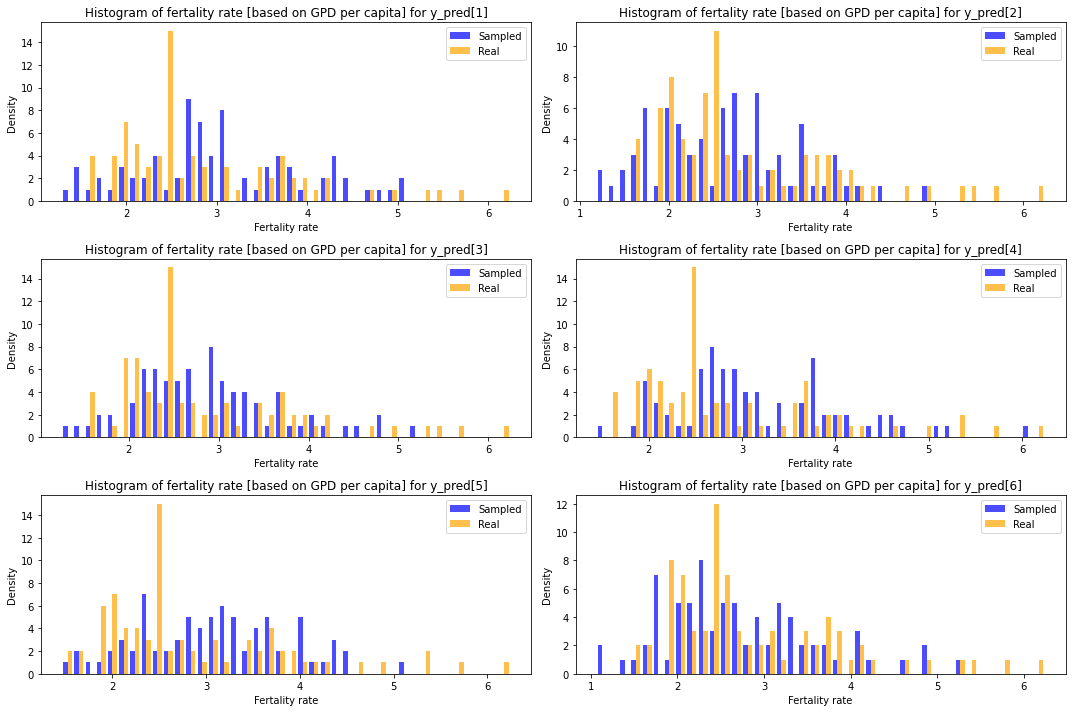

In [41]:
plt.figure(figsize=(15,10))
for idx in range(1,7):
    plt.subplot(3,2,idx)
    plt.title(f'Histogram of fertality rate [based on GPD per capita] for y_pred[{idx}]')
    plt.hist([sim_post_gdp_df[f'y_pred[{idx}]'], training_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Fertality rate')
    plt.tight_layout()
plt.show()

From the histograms, we can conclude that the sampled data accurately covers almost the entire range of fertility rate values. It also tends to cover the peaks at the beginning very well. Since the linear model implemented here is used as a shape parameter for the gamma distribution for different values of GDP per capita, the results shown in the histograms tend to shift slightly, which is controlled as expected by the beta parameter.

Moreover, we decided to implement an additional prediction test. We extracted the alpha and beta parameters used to calculate the shape for gamma distribution in the posterior model and adjusted these values by likelihood to perform predictions on data not included in the training dataset. This data forms the basis of sampling in the new model, which aims to predict ferility rate.

In [42]:
gdp_alpha_samples = sim_post_gdp.stan_variable('alpha')
gdp_beta_gdp_samples = sim_post_gdp.stan_variable('beta_gdp')

In [43]:
gdp_predict = CmdStanModel(stan_file='/home/posterior_gdp_predict.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Model for predictions:

In [44]:
"""
data {
  int<lower=0> N_predict;              
  array[N_predict] real gdp_per_capita_predict;
  array[N_predict] real alpha_predict;
  array[N_predict] real beta_gdp_predict;
  real<lower=0> rate;
}

generated quantities {
  array[N_predict] real y_pred;
  for (j in 1:N_predict) {
    real shape_adjusted = alpha_predict[j] + beta_gdp_predict[j] * gdp_per_capita_predict[j];
    y_pred[j] = gamma_rng(shape_adjusted, rate);
  }
}
"""

'\ndata {\n  int<lower=0> N_predict;              \n  array[N_predict] real gdp_per_capita_predict;\n  array[N_predict] real alpha_predict;\n  array[N_predict] real beta_gdp_predict;\n  real<lower=0> rate;\n}\n\ngenerated quantities {\n  array[N_predict] real y_pred;\n  for (j in 1:N_predict) {\n    real shape_adjusted = alpha_predict[j] + beta_gdp_predict[j] * gdp_per_capita_predict[j];\n    y_pred[j] = gamma_rng(shape_adjusted, rate);\n  }\n}\n'

In [45]:
gdp_predict_data = {
    'N_predict' : len(test_df),
    'gdp_per_capita_predict' : test_df['GDP per capita'].values,
    'alpha_predict' : gdp_alpha_samples[:len(test_df)],
    'beta_gdp_predict' : gdp_beta_gdp_samples[:len(test_df)],
    'rate' : data_simulation_gdp_post['rate']
}

sim_predicted_gdp = gdp_predict.sample(data=gdp_predict_data, seed=2001)
sim_predicted_gdp_df = sim_predicted_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Based on predictions we calculated mean prediction value. Which was used for further analysis.

In [46]:
columns = sim_predicted_gdp_df.columns[2:] ##first two columns irrelevant

predicted_gdp_df = sim_predicted_gdp_df[columns]

In [47]:
gdp_mean_predictions = np.mean(predicted_gdp_df, axis=0)
gdp_median_predictions = np.median(predicted_gdp_df, axis=0)

print("Mean of GDP predictions: ", gdp_mean_predictions)
print("Mean of GDP predictions: ", gdp_median_predictions)

Mean of GDP predictions:  y_pred[1]     1.511983
y_pred[2]     2.233410
y_pred[3]     2.229102
y_pred[4]     1.509857
y_pred[5]     0.496015
y_pred[6]     2.737470
y_pred[7]     1.421490
y_pred[8]     1.953061
y_pred[9]     2.042370
y_pred[10]    1.415396
y_pred[11]    0.271614
y_pred[12]    2.034983
dtype: float64
Mean of GDP predictions:  [1.43718   2.155895  2.15439   1.41875   0.410384  2.659595  1.348145
 1.87263   1.951115  1.337835  0.1892895 1.967245 ]


In [48]:
years = test_df['Year']
entity = test_df['Entity']

gdp_skeleton = {'Entity' : entity, 
            'Year' : years,
            'Fertility rate' : gdp_mean_predictions.values}

gdp_predictions_df = pd.DataFrame(gdp_skeleton)

In [49]:
min_year = gdp_predictions_df['Year'].min()
max_year = gdp_predictions_df['Year'].max()

year_vector = np.linspace(min_year, max_year, len(gdp_predictions_df['Year'].unique()))

Then we visualized our predictions in comparison to the real data, with distinctions for each country.

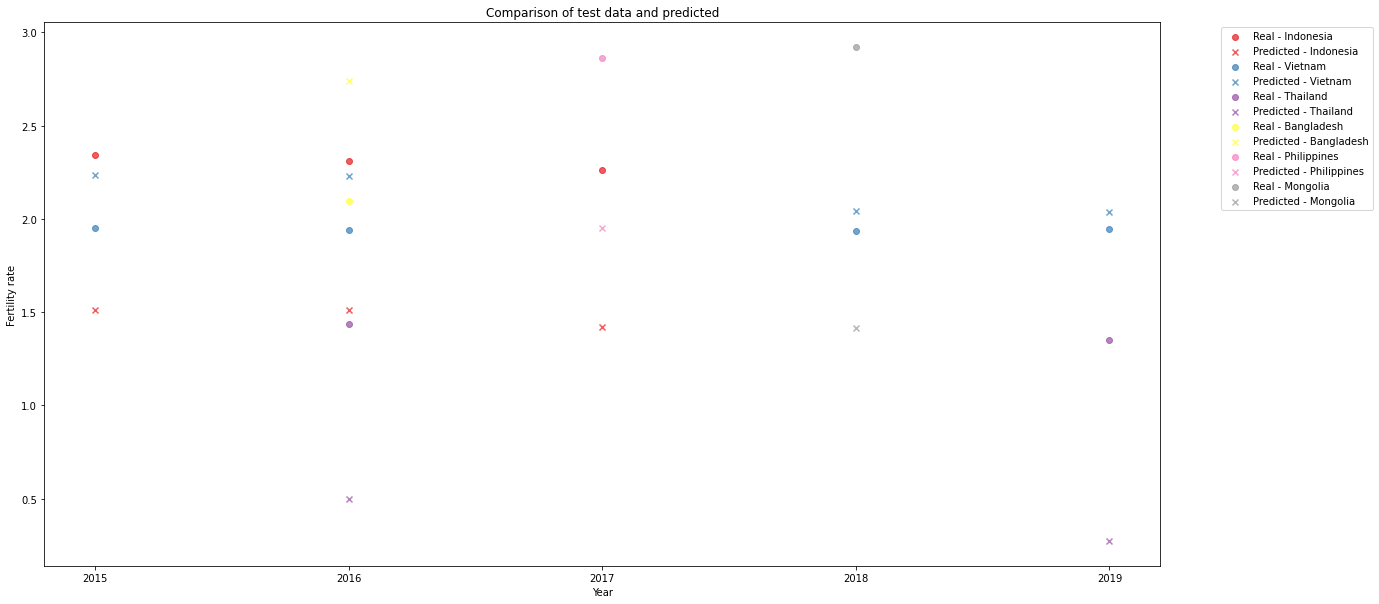

In [50]:
entities = test_df['Entity'].unique()

plt.figure(figsize=(20, 10))
plt.title("Comparison of test data and predicted")

colors = plt.cm.Set1(np.linspace(0, 1, len(entities)))

for i, entity in enumerate(entities):
    real_data = test_df[test_df['Entity'] == entity]
    predicted_data = gdp_predictions_df[gdp_predictions_df['Entity'] == entity]

    plt.scatter(real_data['Year'], real_data['Fertility rate'], color=colors[i], label=f'Real - {entity}', alpha=0.7)
    plt.scatter(predicted_data['Year'], predicted_data['Fertility rate'], color=colors[i], marker='x', label=f'Predicted - {entity}', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Fertility rate")
plt.xticks(year_vector)
plt.show()

Based on the achieved results, we can say that countries with more data included in the training set tend to have better prediction accuracy. Countries like Mongolia or Thailand, with a lower amount of data in the training set, seem to be predicted less accurately. However, countries with more data tend to have more predictable distributions.

## Posterior analysis - model 2

We prepared model for posterior analysis with combined parameters.

In [51]:
posterior_combined = CmdStanModel(stan_file='/home/posterior_combined.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Posterior model in stan:

In [52]:
"""
data {
  int<lower=0> N;               
  array[N] real gdp_per_capita;
  array[N] real labor_force;
  array[N] real contaceptive_prevalence;
  array[N] real fertility_rate;
  real mu_alpha;
  real sig_alpha;
  real mu_beta;
  real sig_beta;
  real<lower=0> rate;
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta_var;
}

model {
  alpha ~ normal(mu_alpha, sig_alpha);
  beta_var ~ normal(mu_beta, sig_beta);

  for (j in 1:N) {
    real shape_adjust = (alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));
    fertility_rate[j] ~ gamma(shape_adjust, rate);
  }
}

generated quantities {
  array[N] real y_pred;
  array[N] real log_likelihood;
  for (j in 1:N) {
    real shape_adjusted = (alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));
    y_pred[j] = gamma_rng(shape_adjusted, rate);
    log_likelihood[j] = gamma_lpdf(fertility_rate[j] | shape_adjusted, rate);
  }
}
"""

'\ndata {\n  int<lower=0> N;               \n  array[N] real gdp_per_capita;\n  array[N] real labor_force;\n  array[N] real contaceptive_prevalence;\n  array[N] real fertility_rate;\n  real mu_alpha;\n  real sig_alpha;\n  real mu_beta;\n  real sig_beta;\n  real<lower=0> rate;\n}\n\nparameters {\n  real<lower=0> alpha;\n  real<lower=0> beta_var;\n}\n\nmodel {\n  alpha ~ normal(mu_alpha, sig_alpha);\n  beta_var ~ normal(mu_beta, sig_beta);\n\n  for (j in 1:N) {\n    real shape_adjust = (alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));\n    fertility_rate[j] ~ gamma(shape_adjust, rate);\n  }\n}\n\ngenerated quantities {\n  array[N] real y_pred;\n  array[N] real log_likelihood;\n  for (j in 1:N) {\n    real shape_adjusted = (alpha + beta_var * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));\n    y_pred[j] = gamma_rng(shape_adjusted, rate);\n    log_likelihood[j] = gamma_lpdf(fertility_rate[j] | shape_adjusted, rate);\n  }\n}\n'

We used data provided from priors in terms of the alpha and beta parameters for the normal distribution, which were further used in sampling.

In [53]:
data_simulation_posterior_combined = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'labor_force' : training_df['Labor force rate'],
    'contaceptive_prevalence' : training_df['Contraceptive prevalence'], 
    'fertility_rate' : training_df['Fertility rate'].values,
    'mu_alpha': np.log(training_df['Fertility rate'].mean()),
    'sig_alpha': np.abs(np.log(training_df['Fertility rate'].std())),
    'mu_beta': 1.5,
    'sig_beta': 0.01,
    'rate' : 1.35
}


We have trained our model with training data in order to obtain alpha and beta which were used in predictions.

In [54]:
R = len(training_df)

sim_combined = posterior_combined.sample(data=data_simulation_posterior_combined, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_post_combined_df = sim_combined.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


After successfull sampling we used a histogram to show the distribution of our data and to determine whether it accurately represents the original data.

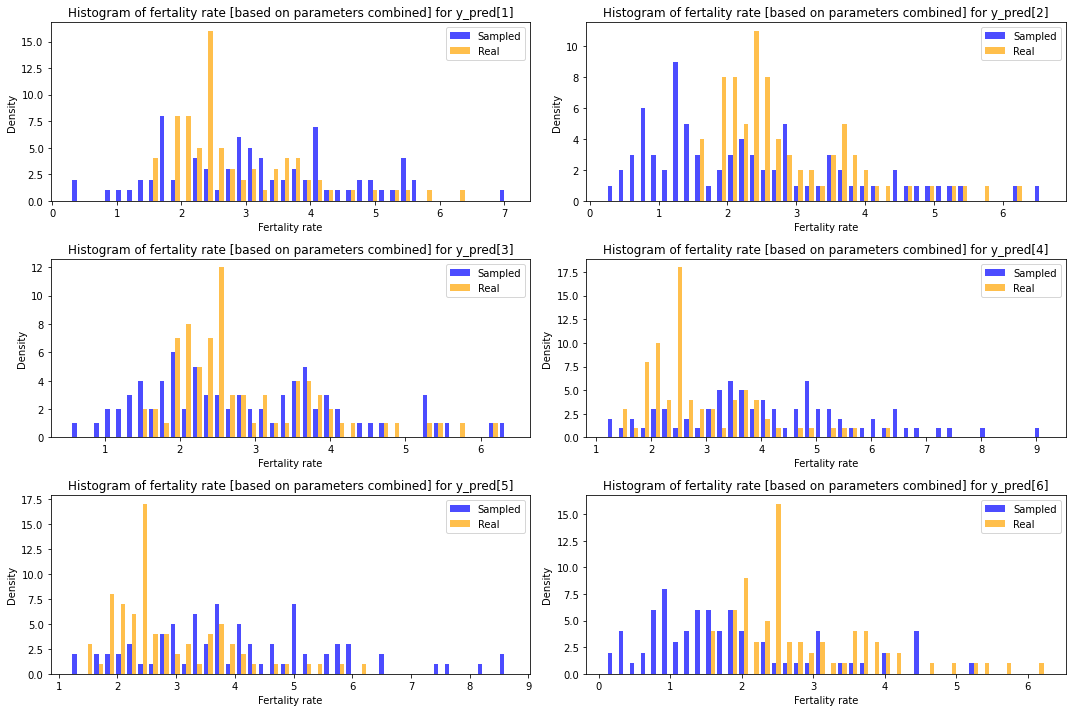

In [55]:
plt.figure(figsize=(15,10))
for idx in range(1,7):
    plt.subplot(3,2,idx)
    plt.title(f'Histogram of fertality rate [based on parameters combined] for y_pred[{idx}]')
    plt.hist([sim_post_combined_df[f'y_pred[{idx}]'], training_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Fertality rate')
    plt.tight_layout()
plt.show()

From the histograms, we can conclude that the data are characterized by a great spread of values, covering almost the entire range of fertility rates. However, since we normalized our data using min-max normalization, we observed an irregular distribution. This is a consequence of the original characteristics of the data. Our linear model is used as shape parameter for gamma distribution, and changes in this parameter result in different shifts in the data. Nonetheless, the chosen parameters have the best overall performance among those tested for the linear model.

Moreover, just like in posterior model 1, we decided to run an additional prediction test. We extracted the alpha and beta parameters used for the calculations and created a model based on the posterior. The goal was to predict fertility rates using new data sent to the model. The new data was the test dataframe created at the beginning of our analysis. Afterwards, we sampled the model and stored the results in a dataframe.

In [56]:
combined_alpha_samples = sim_combined.stan_variable('alpha')
combined_beta_var_samples = sim_combined.stan_variable('beta_var')

In [57]:
combined_predict = CmdStanModel(stan_file='/home/posterior_combined_predict.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


Model for predictions:

In [58]:
"""
data {
  int<lower=0> N_predict;               
  array[N_predict] real gdp_per_capita;
  array[N_predict] real labor_force;
  array[N_predict] real contaceptive_prevalence;
  array[N_predict] real alpha_predict;
  array[N_predict] real beta_gdp_predict;
  real<lower=0> rate;
}

generated quantities {
  array[N_predict] real y_pred;
  for (j in 1:N_predict) {
    real shape_adjusted = (alpha_predict[j] + beta_gdp_predict[j] * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));
    y_pred[j] = gamma_rng(shape_adjusted, rate);
  }
}
"""

'\ndata {\n  int<lower=0> N_predict;               \n  array[N_predict] real gdp_per_capita;\n  array[N_predict] real labor_force;\n  array[N_predict] real contaceptive_prevalence;\n  array[N_predict] real alpha_predict;\n  array[N_predict] real beta_gdp_predict;\n  real<lower=0> rate;\n}\n\ngenerated quantities {\n  array[N_predict] real y_pred;\n  for (j in 1:N_predict) {\n    real shape_adjusted = (alpha_predict[j] + beta_gdp_predict[j] * (gdp_per_capita[j] + labor_force[j] + contaceptive_prevalence[j]));\n    y_pred[j] = gamma_rng(shape_adjusted, rate);\n  }\n}\n'

In [59]:
combined_predict_data = {
    'N_predict' : len(test_df),
    'gdp_per_capita' : test_df['GDP per capita'].values,
    'labor_force' : test_df['Labor force rate'],
    'contaceptive_prevalence' : test_df['Contraceptive prevalence'],
    'alpha_predict' : combined_alpha_samples[:len(test_df)],
    'beta_gdp_predict' : combined_beta_var_samples[:len(test_df)],
    'rate' : data_simulation_posterior_combined['rate']
}

sim_predicted_combined = combined_predict.sample(data=combined_predict_data, seed=2001)
sim_predicted_combined_df = sim_predicted_combined.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▋       | 00:00 Iteration: 400 / 1000 [ 40%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Based on predictions we calculated mean prediction value. Which was used for further analysis.

In [60]:
columns = sim_predicted_combined_df.columns[2:]

predicted_combined_df = sim_predicted_combined_df[columns]

In [61]:
combined_mean_predictions = np.mean(predicted_combined_df, axis=0)
combined_median_predictions = np.median(predicted_combined_df, axis=0)

print("Mean of combined predictions: ", combined_mean_predictions)
print("Mean of combined predictions: ", combined_median_predictions)

Mean of combined predictions:  y_pred[1]     2.064757
y_pred[2]     1.702140
y_pred[3]     1.649635
y_pred[4]     2.024675
y_pred[5]     1.170258
y_pred[6]     2.685970
y_pred[7]     1.891357
y_pred[8]     2.372954
y_pred[9]     1.663677
y_pred[10]    2.236288
y_pred[11]    1.165325
y_pred[12]    1.608953
dtype: float64
Mean of combined predictions:  [1.82827  1.431985 1.4188   1.787245 0.914906 2.46698  1.662815 2.1494
 1.42833  1.98529  0.935189 1.362595]


In [62]:
years = test_df['Year']
entity = test_df['Entity']

combined_skeleton = {'Entity' : entity,
            'Year' : years,
            'Fertility rate' : combined_mean_predictions.values}

combined_predictions_df = pd.DataFrame(combined_skeleton)

In [63]:
min_year = combined_predictions_df['Year'].min()
max_year = combined_predictions_df['Year'].max()

year_vector = np.linspace(min_year, max_year, len(combined_predictions_df['Year'].unique()))

Then we visualized our predictions in comparison to the real data, with distinctions for each country.

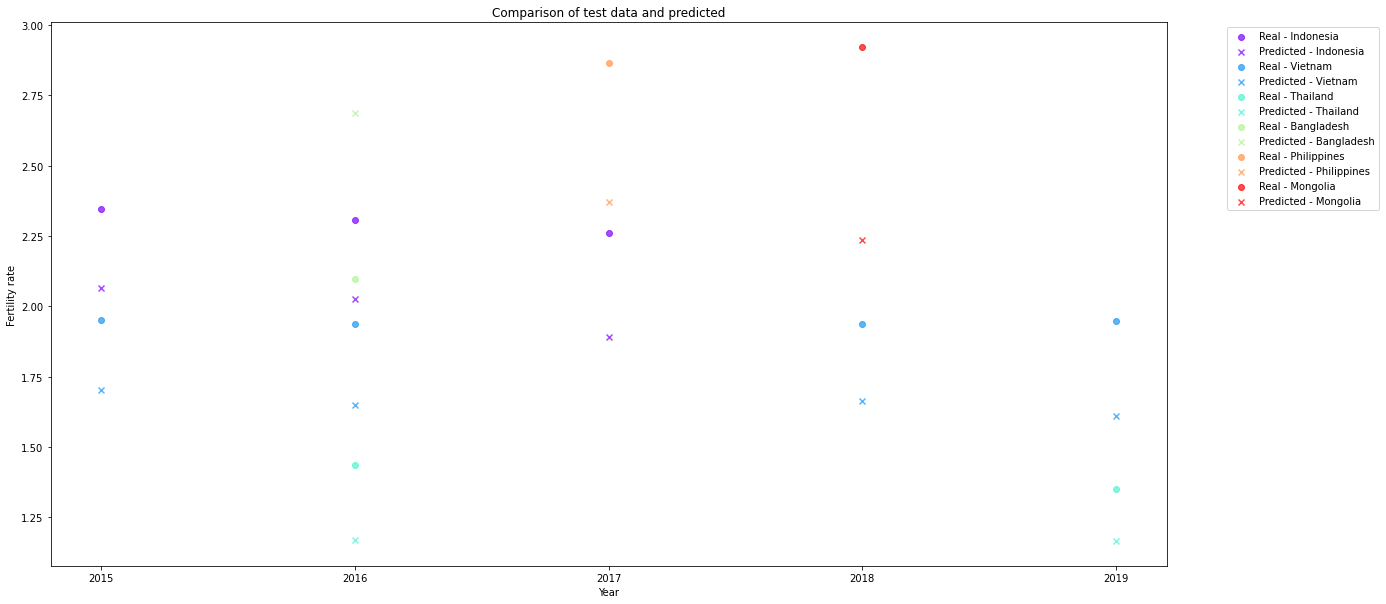

In [64]:
entities = test_df['Entity'].unique()

plt.figure(figsize=(20, 10))
plt.title("Comparison of test data and predicted")

colors = plt.cm.rainbow(np.linspace(0, 1, len(entities)))

for i, entity in enumerate(entities):
    real_data = test_df[test_df['Entity'] == entity]
    predicted_data = combined_predictions_df[combined_predictions_df['Entity'] == entity]

    plt.scatter(real_data['Year'], real_data['Fertility rate'], color=colors[i], label=f'Real - {entity}', alpha=0.7)
    plt.scatter(predicted_data['Year'], predicted_data['Fertility rate'], color=colors[i], marker='x', label=f'Predicted - {entity}', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Fertility rate")
plt.xticks(year_vector)
plt.show()

Based on the results, we can say that countries with more appearances in the training data tend to be predicted more accurately (with a lower difference between the real and predicted values). For countries with less data, the difference is higher, as expected, since the model did not have enough data to adjust itself.

## Model comparision

To evaluate the performance of both prepared models, we decided to take two approaches. The first approach uses information criteria to assess the accuracy and predictive performance of the models. The second approach evaluates the predictions themselves, using classic machine learning metrics to compare the results with real values.

### Waic and Loo

WAIC (Watanabe-Akaike Information Criteria) and LOO (Leave-One-Out) are both widely used metrics in Bayesian model comparision.

WAIC is a fully Bayesian criterion for model comparison that estimates the out-of-sample predictive accuracy of a model. It is based on the concept of predictive density. 

On the other hand LOO is a cross-validation method that provides an estimate of the out-of-sample predictive performance of a model. It involves systematically leaving out each data point from the dataset one at a time, fitting the model to the remaining data, and then evaluating the model's predictive performance on the omitted data point.

In our case we used values of log likelihood for each datapoints individually, which is being used in both metrics as reference point for calculations.

In [65]:
inf_gdp = az.from_cmdstanpy(sim_post_gdp, log_likelihood="log_likelihood")
inf_combo = az.from_cmdstanpy(sim_combined, log_likelihood="log_likelihood")

In [66]:
comp_dict = {"GDP as factor" : inf_gdp, "GDP, Contraception and Labor as factors" : inf_combo}

In [67]:
compare_waic = az.compare(comp_dict, ic='waic')
compare_loo = az.compare(comp_dict, ic='loo')

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


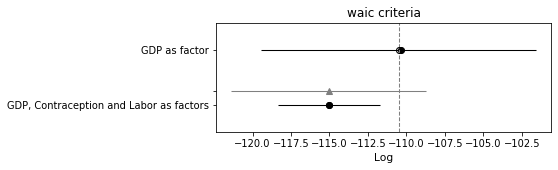

In [68]:
ax = az.plot_compare(compare_waic)
ax.set_title('waic criteria')
plt.show()

The model "GDP as a factor" achieved a score around -110, while the second model scored around -115. Horizontal lines represent standard errors, which are wider for the first model, indicated by the broader line compared to the second model.

The model "GDP, Contraception, and Labor as factors" has a lower score, suggesting better predictive performance. There is also a slight overlap between the standard errors of both models, with the second model's error concluded to be inside the standard error of the first. This overlap indicates that based solely on the WAIC metric, we cannot conclusively say that one model is significantly better than the other.

In summary, there is no clear winner, the WAIC metric does not provide a straightforward answer regarding which model is better.

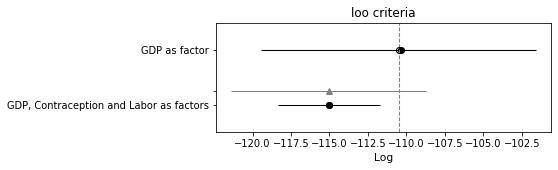

In [69]:
ax = az.plot_compare(compare_loo)
ax.set_title('loo criteria')
plt.show()

Just like in the WAIC metric for LOO, the model "GDP as a factor" achieved a score around -110, while the second model scored around -115. Horizontal lines represent standard errors, which are wider for the first model, indicated by the broader line compared to the second model.

The second model also has a lower score, indicating better predictive performance. However, similar to the previous case, the standard error of the first model overlaps with the standard error of the second model. Because of this overlap, we cannot definitively say that one model is better than the other based on the LOO metric.

In summary, there is also no clear winner; the LOO metric does not provide enough information to determine which model is better.

### Prediction comparision

Since we are predicting the fertility rate, which is given as a real value, we have decided to use classic accuracy metrics such as RMSE (Root Mean Square Error) and MAE (Mean Absolute Error). Firstly, we presented on one plot each prediction alongside the real value and predictions from both models. This makes it easier to evaluate the results.

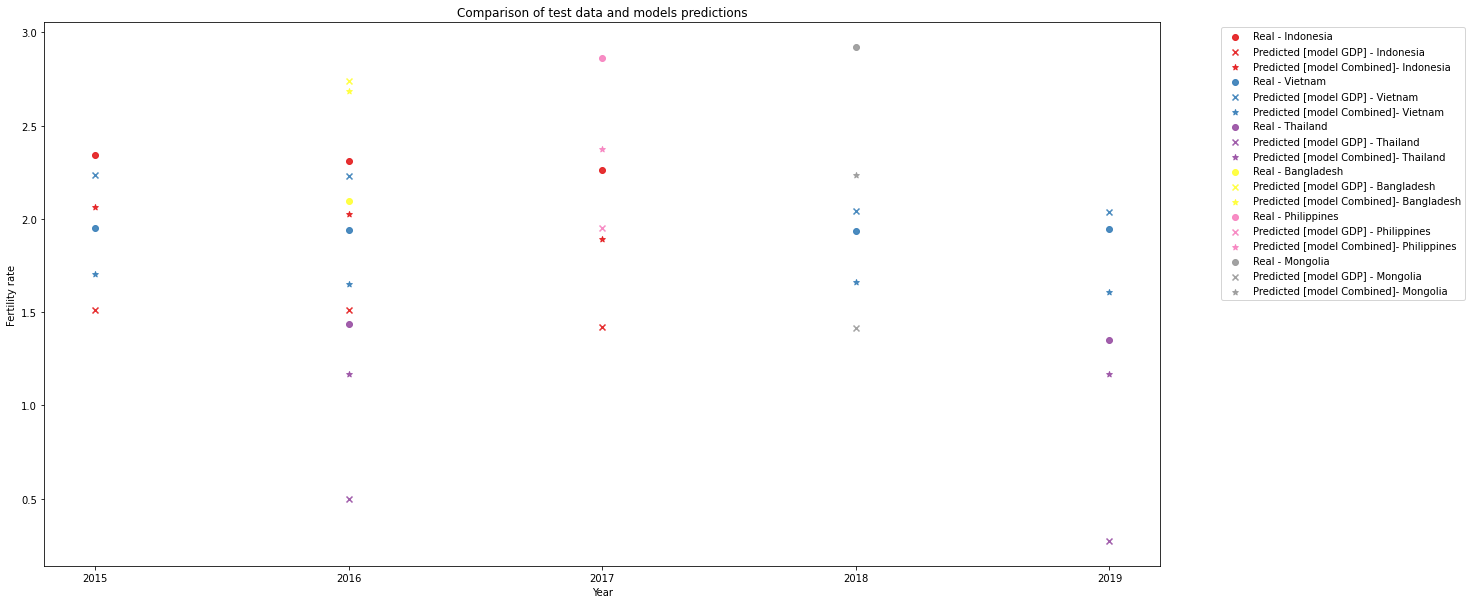

In [70]:
entities = test_df['Entity'].unique()

plt.figure(figsize=(20, 10))
plt.title("Comparison of test data and models predictions")

colors = plt.cm.Set1(np.linspace(0, 1, len(entities)))

for i, entity in enumerate(entities):
    real_data = test_df[test_df['Entity'] == entity]
    predicted_gdp = gdp_predictions_df[gdp_predictions_df['Entity'] == entity]
    predicted_combined = combined_predictions_df[combined_predictions_df['Entity'] == entity]


    plt.scatter(real_data['Year'], real_data['Fertility rate'], color=colors[i], label=f'Real - {entity}', alpha=0.9)
    plt.scatter(predicted_gdp['Year'], predicted_gdp['Fertility rate'], color=colors[i], marker='x', label=f'Predicted [model GDP] - {entity}', alpha=0.9)
    plt.scatter(predicted_combined['Year'], predicted_combined['Fertility rate'], color=colors[i], marker='*', label=f'Predicted [model Combined]- {entity}', alpha=0.9)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Fertility rate")
plt.xticks(year_vector)
plt.show()

Based on predictions and expected values from the test dataset, we used RMSE and MAE metrics to further evaluate the accuracy of the models.

In [71]:
y_true = test_df['Fertility rate'].values
y_pred_model1 = gdp_predictions_df['Fertility rate'].values
y_pred_model2 = combined_predictions_df['Fertility rate'].values

print('GDP model:')
print(f'Mean absolute error: {mean_absolute_error(y_true, y_pred_model1)}')
print(f'Root mean square error: {root_mean_squared_error(y_true, y_pred_model1)}')

print('Combined parameters model:')
print(f'Mean absolute error: {mean_absolute_error(y_true, y_pred_model2)}')
print(f'Root mean square error: {root_mean_squared_error(y_true, y_pred_model2)}')

GDP model:
Mean absolute error: 0.6930682902047168
Root mean square error: 0.8054230107623099
Combined parameters model:
Mean absolute error: 0.35865418657854153
Root mean square error: 0.3869339408205054


The combined parameters model is better than the GDP model because it achieves lower values for both Mean Absolute Error (MAE) and Root Mean Square Error (RMSE). This indicates that the Combined parameters model makes more accurate predictions overall and has a smaller average deviation from the actual values compared to the GDP model.

### Conclusions from model comparision

The first model, based on GDP per capita, was compared against the second model, which incorporated combined parameters. Metrics like LOO (Leave-One-Out Cross-Validation) and WAIC (Watanabe-Akaike Information Criterion) were utilized. Although these metrics did not provide a definitive answer, they indicated that the second model performed slightly better than the first.

Further assessment using prediction metrics, specifically RMSE (Root Mean Square Error) and MAE (Mean Absolute Error), provided clearer insights. Lower values of MAE and RMSE indicate better predictive accuracy. The second model, leveraging combined parameters, demonstrated significantly reduced errors compared to the GDP model.

As expected, the model predicting fertility rate based on more parameters proved to be more accurate in its predictions. We anticipated this outcome because the combined model makes decisions based on a broader set of factors, leading to more reliable results. While we agree with the achieved results, we observed that the differences between the models in terms of WAIC and LOO metrics were lower than expected. Additionally, we believe the second model is better suited for future predictions as it considers more factors that could enhance accuracy.

ertility rate is a complex indicator influenced by various factors, so it is crucial to consider them carefully during analysis.